# Домашнее задание №3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

In [261]:
# загрузка датасета
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# разделение датасета
from sklearn.model_selection import train_test_split

# преобразование данных
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms

#построение модели
import torch
import torch.nn as nn
import torch.nn.functional as F

# метрика
import torchmetrics

#отрисовка графиков
from matplotlib import pyplot as plt 

## Задание

1. Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing, train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25)

2. Обернуть его в Dataloader

3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

4. Сравнить сходимость Adam, RMSProp и SGD, сделать вывод по качеству работы модели

## План работы

[0. Загрузка данных](#section_0)

[1. Dataset и Dataloader](#section_1)

[2. Построение нейронной сети](#section_2)

[3. Модели нейронной сети с разными оптимизаторами](#section_3)

[4. Сводная таблица метрик моделей и вывод](#section_4)

## 0. Загрузка данных<a id='section_0'></a>

In [262]:
housing = fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)
df = housing['frame']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [263]:
# пропусков в данных нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [264]:
# целевая переменная
target = housing['target_names'][0]
target

'MedHouseVal'

In [265]:
# список признаков
features_list = housing['feature_names']
features_list

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [266]:
# собираем признаки и целевую переменную
X = df[features_list]
y = df[target]

In [267]:
# разделяем датасет на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
print(f'Тренировочный набор: {X_train.shape}, {y_train.shape}')
print(f'Тестовый набор: {X_test.shape}, {y_test.shape}')

Тренировочный набор: (15480, 8), (15480,)
Тестовый набор: (5160, 8), (5160,)


In [268]:
#стандартизация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).float()
y_train = torch.FloatTensor(y_train.values).float()

X_test = torch.FloatTensor(X_test).float()
y_test = torch.FloatTensor(y_test.values).float()

## 1. Dataset и Dataloader <a id='section_1'></a>

In [269]:
# класс датасета
class MyOwnClass(torch.utils.data.Dataset):
   
    def __init__(self, X_data, y_data):
        self._X = X_data
        self._y = y_data

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        X = self._X[idx] 
        y = self._y[idx] 
       
        return X, y

In [270]:
# создание представителя тренировочного датасета и его dataloader
train_dataset = MyOwnClass(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [271]:
# элементы тренировочного датасета
train_dataset[0], train_dataset[0][0].shape, train_dataset[0][1].shape 

((tensor([0.2081, 0.6863, 0.0243, 0.0226, 0.0379, 0.0011, 0.1775, 0.6096]),
  tensor(2.6800)),
 torch.Size([8]),
 torch.Size([]))

In [272]:
# элементы тренировочного даталоадера
for idx, batch in enumerate(train_loader):
    print(idx, 'Tensor: ', batch[0], batch[0].shape)  # 128 батчей с 8 признаками
    print(idx, 'target: ', batch[1], batch[1].shape)  # 128 значений target
    break

0 Tensor:  tensor([[0.2485, 0.3529, 0.0206,  ..., 0.0017, 0.1180, 0.6414],
        [0.2252, 0.3137, 0.0300,  ..., 0.0019, 0.0202, 0.7321],
        [0.1435, 0.8235, 0.0309,  ..., 0.0013, 0.8587, 0.0219],
        ...,
        [0.0814, 0.9412, 0.0060,  ..., 0.0019, 0.1637, 0.6036],
        [0.2296, 0.6863, 0.0395,  ..., 0.0013, 0.1711, 0.7042],
        [0.2653, 0.5686, 0.0285,  ..., 0.0017, 0.4315, 0.2510]]) torch.Size([128, 8])
0 target:  tensor([2.1340, 1.2760, 0.9210, 2.5290, 4.1480, 1.9100, 1.6250, 1.3420, 1.8750,
        1.9810, 1.3550, 1.9040, 1.2300, 3.0040, 0.5880, 2.7130, 0.5510, 2.8610,
        1.3440, 2.2860, 2.7980, 1.3970, 1.5680, 2.0940, 1.3390, 1.6090, 1.7980,
        2.2500, 3.4060, 2.5360, 1.3700, 2.0000, 1.4570, 0.6290, 0.7760, 2.8030,
        2.7180, 0.7680, 1.6270, 2.8750, 3.4320, 3.0000, 2.7940, 1.1180, 4.8750,
        2.9350, 0.5920, 1.8610, 3.6860, 2.0950, 5.0000, 1.2980, 2.3760, 0.8570,
        2.9440, 1.9190, 3.7430, 4.2220, 2.0740, 2.0860, 2.1070, 1.2280, 1.4190,

In [273]:
# создание представителя тестового датасета и его dataloader
test_dataset = MyOwnClass(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=8,
                                          shuffle=False,
                                          drop_last=True,
                                          num_workers=0)

## 2. Построение нейронной сети <a id='section_2'></a>

In [274]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        raise RuntimeError
        
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [275]:
# инициализация модели
net = FeedForward(8, 400)

# компиляция модели
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [276]:
num_epochs = 10

train_r2 = torchmetrics.R2Score()
test_r2 = torchmetrics.R2Score()

net.train()

for epoch in range(num_epochs):  
    
    running_loss, running_items = 0.0, 0.0
    
    for i, data in enumerate(train_loader):
        inputs, target = data[0], data[1]
        
        optimizer.zero_grad()
        outputs = net(inputs)
        train_r2(outputs.squeeze(), target)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(target)
  
        # выводим статистику о процессе обучения
        if i % 60 == 0:    # печатаем каждые 60 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}, ', \
                  f'r2_train: {train_r2.compute().item():.3f}, ', end = ' ')
            running_loss, running_items = 0.0, 0.0
            train_r2.reset()

            for i, data in enumerate(test_loader):
                test_outputs = net(data[0])
                test_r2(test_outputs.squeeze(), data[1])
            
            print(f'r2_val: {test_r2.compute():.3f}')
            test_r2.reset()
            net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/120]. Loss: 4.833,  r2_train: -2.916,  r2_val: -3.014
Epoch [1/10]. Step [61/120]. Loss: 1.529,  r2_train: -0.169,  r2_val: 0.376
Epoch [2/10]. Step [1/120]. Loss: 0.774,  r2_train: 0.381,  r2_val: 0.526
Epoch [2/10]. Step [61/120]. Loss: 0.709,  r2_train: 0.463,  r2_val: 0.515
Epoch [3/10]. Step [1/120]. Loss: 0.673,  r2_train: 0.509,  r2_val: 0.611
Epoch [3/10]. Step [61/120]. Loss: 0.566,  r2_train: 0.569,  r2_val: 0.602
Epoch [4/10]. Step [1/120]. Loss: 0.401,  r2_train: 0.596,  r2_val: 0.643
Epoch [4/10]. Step [61/120]. Loss: 0.483,  r2_train: 0.636,  r2_val: 0.661
Epoch [5/10]. Step [1/120]. Loss: 0.472,  r2_train: 0.637,  r2_val: 0.670
Epoch [5/10]. Step [61/120]. Loss: 0.462,  r2_train: 0.655,  r2_val: 0.642
Epoch [6/10]. Step [1/120]. Loss: 0.601,  r2_train: 0.646,  r2_val: 0.682
Epoch [6/10]. Step [61/120]. Loss: 0.442,  r2_train: 0.668,  r2_val: 0.653
Epoch [7/10]. Step [1/120]. Loss: 0.569,  r2_train: 0.679,  r2_val: 0.717
Epoch [7/10]. Step [61/120]. 

## 3. Модели нейронной сети с разными оптимизаторами <a id='section_3'></a>

In [277]:
def train_eval_model(model, optimizer, num_epochs):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()
    
    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1] # входные данные с лейблами
            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = model(inputs)
            #метрика
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            # Вычисляем градиент
            loss.backward()
            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()
        
        model.eval()
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_val = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()
    
    return r2_train_list, r2_test_list

In [278]:
# функция визуализации метрик
def visual_metrics(r2_train_list, r2_test_list, optim):
    x = np.arange(1,11,1)
    y = r2_train_list
    y2 = r2_test_list

    plt.plot(x,y,label='R2_train')
    plt.plot(x,y2,label='R2_test')

    plt.title(f"NN with optim {optim}")   
    plt.ylabel('R2_score')   
    plt.xlabel('epochs')   
    plt.legend()
    plt.show()

In [279]:
torch.manual_seed(10)

#### Оптимизатор SGD

In [280]:
model = FeedForward(8, 400)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum =0.0)
r2_train_list_SGD, r2_test_list_SGD = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = -0.06717300415039062, r2_val = 0.41210412979125977
Epoch 2: r2_train = 0.40845155715942383, r2_val = 0.5378795862197876
Epoch 3: r2_train = 0.4770476818084717, r2_val = 0.5311636924743652
Epoch 4: r2_train = 0.5188525319099426, r2_val = 0.5454289317131042
Epoch 5: r2_train = 0.5516307353973389, r2_val = 0.602898120880127
Epoch 6: r2_train = 0.576067328453064, r2_val = 0.6236855983734131
Epoch 7: r2_train = 0.6157393455505371, r2_val = 0.6544851660728455
Epoch 8: r2_train = 0.6434617042541504, r2_val = 0.6947653293609619
Epoch 9: r2_train = 0.6668272614479065, r2_val = 0.722545862197876
Epoch 10: r2_train = 0.6796253323554993, r2_val = 0.7246508598327637


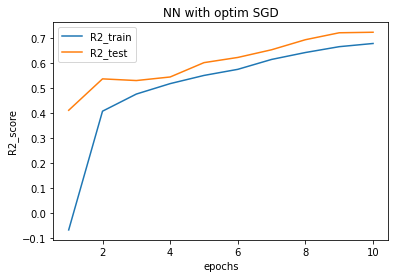

In [281]:
visual_metrics(r2_train_list_SGD, r2_test_list_SGD, 'SGD')

#### Оптимизатор Adam

In [282]:
model = FeedForward(8, 400)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
r2_train_list_Adam, r2_test_list_Adam = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.14378339052200317, r2_val = 0.4993569254875183
Epoch 2: r2_train = 0.49837738275527954, r2_val = 0.6042308807373047
Epoch 3: r2_train = 0.5913742184638977, r2_val = 0.6209152936935425
Epoch 4: r2_train = 0.6320275664329529, r2_val = 0.6467678546905518
Epoch 5: r2_train = 0.6667019128799438, r2_val = 0.6736723184585571
Epoch 6: r2_train = 0.6627976894378662, r2_val = 0.687244176864624
Epoch 7: r2_train = 0.6817501783370972, r2_val = 0.6925489902496338
Epoch 8: r2_train = 0.6976815462112427, r2_val = 0.6562528610229492
Epoch 9: r2_train = 0.6979964971542358, r2_val = 0.7489646077156067
Epoch 10: r2_train = 0.7120413780212402, r2_val = 0.7177854776382446


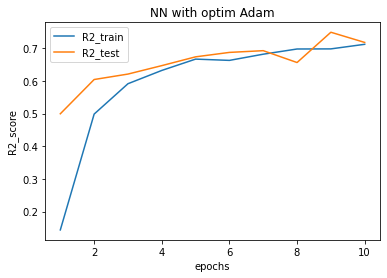

In [283]:
visual_metrics(r2_train_list_Adam, r2_test_list_Adam, 'Adam')

#### Оптимизатор  RMSprop

In [284]:
model = FeedForward(8, 400)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
r2_train_list_RMS, r2_test_list_RMS = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.15949010848999023, r2_val = 0.5158732533454895
Epoch 2: r2_train = 0.5359159708023071, r2_val = 0.6429702639579773
Epoch 3: r2_train = 0.596904993057251, r2_val = 0.6952189207077026
Epoch 4: r2_train = 0.6449277400970459, r2_val = 0.6809487342834473
Epoch 5: r2_train = 0.6623753309249878, r2_val = 0.7263575196266174
Epoch 6: r2_train = 0.6834549903869629, r2_val = 0.7327178716659546
Epoch 7: r2_train = 0.6832114458084106, r2_val = 0.6436749696731567
Epoch 8: r2_train = 0.693267822265625, r2_val = 0.6488761901855469
Epoch 9: r2_train = 0.7011139392852783, r2_val = 0.7382537126541138
Epoch 10: r2_train = 0.7053498029708862, r2_val = 0.7562534213066101


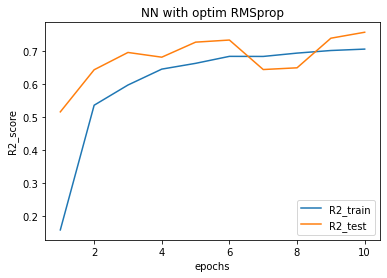

In [285]:
visual_metrics(r2_train_list_RMS, r2_test_list_RMS, 'RMSprop')

## 4. Сводная таблица метрик моделей и вывод <a id='section_4'></a>

In [286]:
# сводная таблица метрик моделей
metrics_result = pd.DataFrame([{'r2_train': r2_train_list_SGD[-1].item(), 'r2_test': r2_test_list_SGD[-1].item()},
                               {'r2_train': r2_train_list_Adam[-1].item(), 'r2_test': r2_test_list_Adam[-1].item()},
                               {'r2_train': r2_train_list_RMS[-1].item(), 'r2_test': r2_test_list_RMS[-1].item()}],
                              index =['SGD', 'Adam', 'RMSprop'], 
                              columns =['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
RMSprop,0.705350,0.756253
SGD,0.679625,0.724651
Adam,0.712041,0.717785


**Вывод:** лучшие показатели модели по метрике достигается с применением оптимизатора RMSprop. 